In [1]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm



ModuleNotFoundError: No module named 'nltk'

In [41]:
train_data= pd.read_csv('/content/Twitter_Data.csv')
train_data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [42]:
train_data.dropna(axis=0, how='any', inplace=True)

In [4]:
train_data.sentiment.value_counts(normalize = True)*100

,proportion
sentiment,
neutral,40.454876
positive,31.229985
negative,28.315138


In [43]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_url(text):
    url_pattern  = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub(r'', text)


def clean_text(text):
    # Convert input to string to handle potential non-string values
    text = str(text)
    delete_dict = {sp_character: '' for sp_character in string.punctuation}
    delete_dict[' '] = ' '
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    textArr = text1.split()
    text2 = ' '.join([w for w in textArr if (not w.isdigit() and len(w) > 2)])
    return text2.lower()


train_data['clean_text'] =train_data['text'].apply(clean_text)
train_data['clean_text'] = train_data['clean_text'].apply(remove_url)
train_data['clean_text'] = train_data['clean_text'].apply(remove_emoji)


def get_sentiment(sentiment):
    if sentiment == 'positive':
        return 2
    elif sentiment == 'negative':
        return 1
    else:
        return 0



In [44]:
train_data['Num_words_text'] = train_data['text'].apply(lambda x: len(str(x).split()))
train_data = train_data[train_data['Num_words_text'] > 2]

# Encode sentiments to integer
label_encoder = LabelEncoder()
train_data['label'] = label_encoder.fit_transform(train_data['sentiment'])

<ipython-input-44-27e30eaceb74>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['label'] = label_encoder.fit_transform(train_data['sentiment'])


In [85]:
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

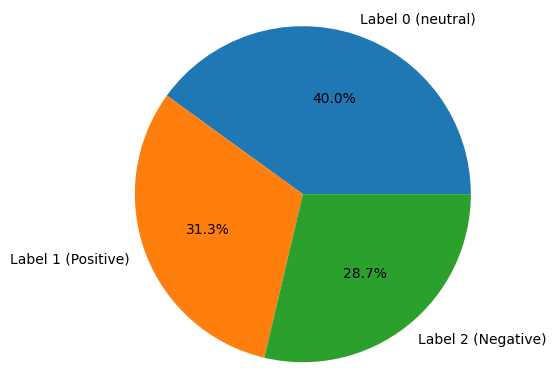

In [45]:
import matplotlib.pyplot as plt

y = train_data['label']
plt.pie(y.value_counts(),
        labels=['Label 0 (neutral)', 'Label 1 (Positive)', 'Label 2 (Negative)'],
        autopct='%0.1f%%')
plt.axis('equal')
plt.show()

In [46]:
X_train, X_test, y_train, y_test = train_test_split(train_data['text'], train_data['label'], test_size=0.2, random_state=42)

In [66]:
vectorizer = TfidfVectorizer(max_features=1000)  # Limit to top 5000 features
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

X_train_vectorized = X_train_vectorized.toarray()
X_test_vectorized = X_test_vectorized.toarray()


In [86]:
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [67]:
X_train_tensor = torch.FloatTensor(X_train_vectorized)
X_test_tensor = torch.FloatTensor(X_test_vectorized)
y_train_tensor = torch.LongTensor(y_train.values)
y_test_tensor = torch.LongTensor(y_test.values)

In [68]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)  # First linear layer
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)  # Leaky ReLU activation
        self.fc2 = nn.Linear(hidden_size, num_classes)  # Second linear layer

    def forward(self, x):
        # Reshape input to (batch_size, seq_length, input_size)
        x = x.unsqueeze(1)

        # LSTM forward pass
        out, (hn, cn) = self.lstm(x)

        # Pass the last hidden state through the first linear layer
        out = self.fc1(hn[-1])

        # Apply Leaky ReLU activation
        out = self.leaky_relu(out)

        # Pass through the second linear layer to get final output
        out = self.fc2(out)

        return out

# Initialize model parameters
input_size = X_train_tensor.shape[1]  # Input feature size
hidden_size = 64                        # Size of LSTM hidden state
num_classes = len(np.unique(y_train))   # Number of output classes

# Instantiate the model
model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)

In [87]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [69]:
input_size

1000

In [72]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop parameters
epochs = 8

for epoch in range(epochs):
    model.train()

    running_loss = 0.0

    for i in tqdm(range(0, len(X_train_tensor), 64)):
        X_batch = X_train_tensor[i:i + 64]
        y_batch = y_train_tensor[i:i + 64]


        optimizer.zero_grad()


        outputs = model(X_batch)


        loss = criterion(outputs, y_batch)
        loss.backward()
        accuracy = (outputs.argmax(dim=1) == y_batch).float().mean()

        # Optimize weights
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(X_train_tensor):.4f}, Accuracy: {accuracy:.4f}')


100%|██████████| 335/335 [00:01<00:00, 189.32it/s]


Epoch [1/8], Loss: 0.0100, Accuracy: 0.6400


100%|██████████| 335/335 [00:01<00:00, 193.04it/s]


Epoch [2/8], Loss: 0.0099, Accuracy: 0.6400


100%|██████████| 335/335 [00:01<00:00, 180.93it/s]


Epoch [3/8], Loss: 0.0097, Accuracy: 0.6400


100%|██████████| 335/335 [00:02<00:00, 135.72it/s]


Epoch [4/8], Loss: 0.0095, Accuracy: 0.6800


100%|██████████| 335/335 [00:02<00:00, 162.40it/s]


Epoch [5/8], Loss: 0.0093, Accuracy: 0.6800


100%|██████████| 335/335 [00:01<00:00, 203.85it/s]


Epoch [6/8], Loss: 0.0091, Accuracy: 0.7200


100%|██████████| 335/335 [00:01<00:00, 199.45it/s]


Epoch [7/8], Loss: 0.0089, Accuracy: 0.7200


100%|██████████| 335/335 [00:01<00:00, 196.54it/s]

Epoch [8/8], Loss: 0.0086, Accuracy: 0.7600


In [74]:
model.eval()

with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor) * 100
print(f'Test Accuracy: {accuracy:.2f}%')


Test Accuracy: 68.16%


In [92]:
text = "that`s not good"
text = clean_text(text)
text_vectorized = vectorizer.transform([text]).toarray()
text_tensor = torch.FloatTensor(text_vectorized)

model.eval()
with torch.no_grad():
    output = model(text_tensor)
    _, predicted = torch.max(output.data, 1)

sentiment_label = label_encoder.inverse_transform(predicted.numpy())
print(f'Predicted Sentiment: {sentiment_label[0]}')

Predicted Sentiment: negative


In [35]:
from sklearn.metrics import confusion_matrix, classification_report
model.eval()

with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    y_pred = predicted.numpy()
    y_true = y_test_tensor.numpy()
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    y_true_labels = label_encoder.inverse_transform(y_true)

    cm = confusion_matrix(y_true_labels, y_pred_labels)
    cr = classification_report(y_true_labels, y_pred_labels)
cm

array([[ 929,  499,  118],
       [ 302, 1492,  338],
       [  73,  384, 1216]])

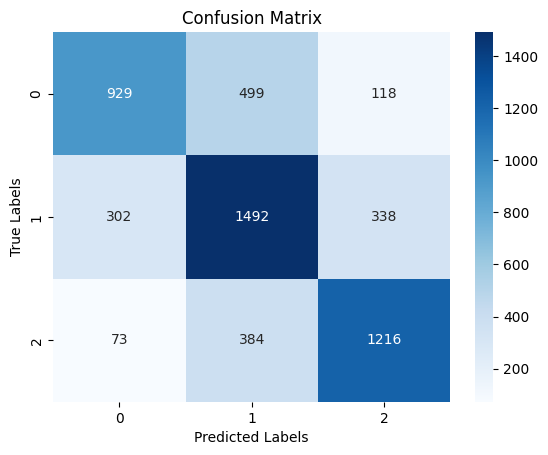

In [36]:
import seaborn as sns

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

mode

> Add blockquote


label encoder
torch numpy flask nltk sikitlearn
vectorizer